In [1]:
import numpy as np
import os
from sklearn.model_selection import KFold
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV

In [2]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_D3_I7000_F9000/TPath_500_finish_data_D3.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.00000,-0.00200,500,7000,9000,669.05
1,0.00000,-0.00196,500,7000,9000,696.80
2,0.00000,-0.00192,500,7000,9000,724.42
3,0.00000,-0.00188,500,7000,9000,751.84
4,0.00000,-0.00184,500,7000,9000,779.83
...,...,...,...,...,...,...
6358,0.00248,0.00184,500,7000,9000,651.36
6359,0.00248,0.00188,500,7000,9000,612.09
6360,0.00248,0.00192,500,7000,9000,584.59
6361,0.00248,0.00196,500,7000,9000,578.64


In [3]:
df = data.drop(data.columns[2:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Temperatur
0,0.00000,-0.00200,669.05
1,0.00000,-0.00196,696.80
2,0.00000,-0.00192,724.42
3,0.00000,-0.00188,751.84
4,0.00000,-0.00184,779.83
...,...,...,...
6358,0.00248,0.00184,651.36
6359,0.00248,0.00188,612.09
6360,0.00248,0.00192,584.59
6361,0.00248,0.00196,578.64


In [4]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen

print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

      X-Koordinate  Y-Koordinate  Temperatur
6243       0.00244       0.00128      978.37
2949       0.00116      -0.00120     1193.00
393        0.00012       0.00160      816.01
3844       0.00152      -0.00176      827.43
2154       0.00084      -0.00068     1419.40
...            ...           ...         ...
3772       0.00148      -0.00060     1381.60
5191       0.00204      -0.00040     1320.60
5226       0.00204       0.00100     1122.50
5390       0.00212      -0.00052     1288.40
860        0.00032       0.00008     1509.50

[6363 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00244,0.00128,978.37
1,0.00116,-0.00120,1193.00
2,0.00012,0.00160,816.01
3,0.00152,-0.00176,827.43
4,0.00084,-0.00068,1419.40
...,...,...,...
6358,0.00148,-0.00060,1381.60
6359,0.00204,-0.00040,1320.60
6360,0.00204,0.00100,1122.50
6361,0.00212,-0.00052,1288.40


In [5]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [6]:
X

,X-Koordinate,Y-Koordinate
0,0.00244,0.00128
1,0.00116,-0.00120
2,0.00012,0.00160
3,0.00152,-0.00176
4,0.00084,-0.00068
...,...,...
6358,0.00148,-0.00060
6359,0.00204,-0.00040
6360,0.00204,0.00100
6361,0.00212,-0.00052


In [7]:
y

0        978.37
1       1193.00
2        816.01
3        827.43
4       1419.40
         ...   
6358    1381.60
6359    1320.60
6360    1122.50
6361    1288.40
6362    1509.50
Name: Temperatur, Length: 6363, dtype: float64

In [8]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [9]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze gleiche Skalierungsparameter ohne das X_Test Informationen einfließen

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [10]:
X_train_scaled

array([[0.96774194, 0.58      ],
       [0.12903226, 0.07      ],
       [0.03225806, 0.07      ],
       ...,
       [0.01612903, 0.25      ],
       [0.67741935, 0.82      ],
       [0.5483871 , 0.65      ]])

In [11]:
y_train_scaled.max()

0.9999999999999999

In [12]:
# Netzwerkarchitektur
model = Sequential([

    Dense(168, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(56, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(328, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(72, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(264, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(120, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(280, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(136, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Trainingsparameter
batch_size = 75
epochs = 500

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/500
55/55 [==============================] - 3s 11ms/step - loss: 0.2387 - mae: 0.3005 - val_loss: 0.1105 - val_mae: 0.1523
Epoch 2/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0904 - mae: 0.1156 - val_loss: 0.0789 - val_mae: 0.1043
Epoch 3/500
55/55 [==============================] - 0s 5ms/step - loss: 0.0626 - mae: 0.0505 - val_loss: 0.0545 - val_mae: 0.0190
Epoch 4/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0520 - mae: 0.0131 - val_loss: 0.0499 - val_mae: 0.0117
Epoch 5/500
55/55 [==============================] - 0s 5ms/step - loss: 0.0483 - mae: 0.0095 - val_loss: 0.0470 - val_mae: 0.0112
Epoch 6/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0460 - mae: 0.0119 - val_loss: 0.0455 - val_mae: 0.0191
Epoch 7/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0446 - mae: 0.0182 - val_loss: 0.0434 - val_mae: 0.0123
Epoch 8/500
55/55 [==============================] - 0s 5ms/step - loss: 0.0429 - 

In [13]:
# Initialisiere Listen, um Ergebnisse zu speichern
val_loss_results = []
val_mae_results = []

# Funktion, um das Modell zu erstellen
def create_model():
    model = Sequential([
                Dense(168, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
            
                Dense(56, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
                
                Dense(328, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
                
                Dense(72, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
                
                Dense(264, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
                
                Dense(120, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
                
                Dense(280, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
                
                Dense(136, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
            
                Dense(1 , activation = 'linear')

    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# K-Fold Cross-Validation Konfiguration
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Leistungsüberwachung
fold_no = 1
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train_scaled[train_index], y_train_scaled[val_index]

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

    print(f'Training für Fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, batch_size=75, epochs=1000, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)

    # Speichere die Ergebnisse des aktuellen Folds
    val_loss_results.append(min(history.history['val_loss']))
    val_mae_results.append(min(history.history['val_mae']))

    fold_no += 1

# Berechne den Durchschnitt über alle Folds
average_val_loss = np.mean(val_loss_results)
average_val_mae = np.mean(val_mae_results)

# Gib die durchschnittlichen Ergebnisse aus
print(f'Durchschnittlicher Validation Loss: {average_val_loss}')
print(f'Durchschnittlicher Validation MAE: {average_val_mae}')


Training für Fold 1...
Epoch 1/1000
55/55 [==============================] - 2s 9ms/step - loss: 0.4655 - mae: 0.3397 - val_loss: 0.2941 - val_mae: 0.2201
Epoch 2/1000
55/55 [==============================] - 0s 4ms/step - loss: 0.2322 - mae: 0.1285 - val_loss: 0.1902 - val_mae: 0.0437
Epoch 3/1000
55/55 [==============================] - 0s 4ms/step - loss: 0.1813 - mae: 0.0417 - val_loss: 0.1712 - val_mae: 0.0289
Epoch 4/1000
55/55 [==============================] - 0s 4ms/step - loss: 0.1655 - mae: 0.0225 - val_loss: 0.1621 - val_mae: 0.0380
Epoch 5/1000
55/55 [==============================] - 0s 4ms/step - loss: 0.1566 - mae: 0.0182 - val_loss: 0.1529 - val_mae: 0.0150
Epoch 6/1000
55/55 [==============================] - 0s 4ms/step - loss: 0.1522 - mae: 0.0317 - val_loss: 0.1558 - val_mae: 0.0730
Epoch 7/1000
55/55 [==============================] - 0s 4ms/step - loss: 0.1500 - mae: 0.0482 - val_loss: 0.1461 - val_mae: 0.0371
Epoch 8/1000
55/55 [==============================] -

In [13]:
results = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
results

40/40 - 0s - loss: 0.0013 - mae: 0.0037 - 64ms/epoch - 2ms/step


[0.0012696175836026669, 0.00365316029638052]

In [14]:

scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[100]} Actual: {original_actual_values[100]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")

 Bsp. Predicted: [1467.9559] Actual: [1463.6] 
Durchschnittliche Abweichung (MAE): [3.45615728]


In [46]:
def calculate_r_squared(predicted, actual):
    # Berechnung des Mittelwerts der tatsächlichen Werte
    mean_actual = sum(actual) / len(actual)
    
    # Berechnung der totalen Summe der Quadrate (SST)
    sst = sum((x - mean_actual) ** 2 for x in actual)
    
    # Berechnung der Summe der Quadrate der Residuen (SSE)
    sse = sum((actual[i] - predicted[i]) ** 2 for i in range(len(actual)))
    
    # Berechnung des R^2-Wertes
    r_squared = 1 - (sse / sst)
    
    return r_squared

# Berechnung von R^2 mit den bereitgestellten Listen
r_squared = calculate_r_squared(list1, list2)

print(f"R^2: {r_squared}")

R^2: [0.99961827]


In [47]:
df_result = pd.DataFrame({'Echt': [val[0] for val in list1], 'Vorhergesagt': [val[0] for val in list2]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]

df_result['Differenz'] = df_result['Echt'] - df_result['Vorhergesagt']
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] < -20).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)

sorted_df

Anzahl der Werte die kleiner sind: 4


,Echt,Vorhergesagt,X-Koordinate,Y-Koordinate,Differenz
302,729.686279,755.11,1.000000,0.93,-25.423721
733,849.313904,874.06,1.000000,0.07,-24.746096
393,802.833862,824.74,0.983871,0.05,-21.906138
715,872.196167,893.58,1.000000,0.08,-21.383833
183,825.964783,845.81,0.967742,0.06,-19.845217
...,...,...,...,...,...
482,679.387512,660.80,0.806452,0.00,18.587512
1127,681.046509,661.84,0.870968,0.00,19.206509
1104,693.178528,672.09,0.983871,0.00,21.088528
1195,691.094849,669.01,0.032258,0.00,22.084849


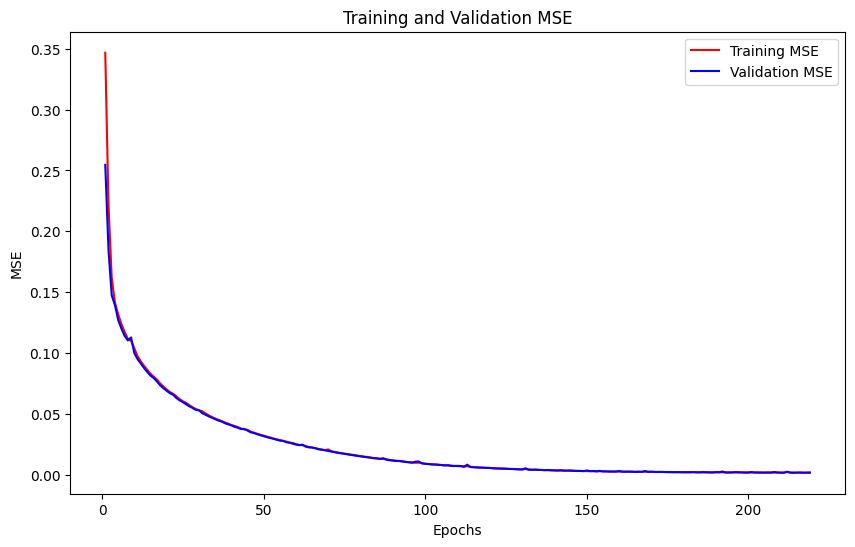

In [48]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MSE')
plt.plot(epochs, val_mae, 'b', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Bilder Diplomarbeit/MSE_NeuroNetz/MSE_NeuroNetz_D3_2')

plt.show()


# GridSearch

In [49]:
# def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
#     model = Sequential()
#     model.add(Dense(200, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(448, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(352, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(320, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(256, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(416, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(128, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(96, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))    
# 
#     model.add(Dense(32, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
#     return model
# 
# # Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
# model = KerasRegressor(model=build_model, verbose=2)
# 
# # Anpassung der Parameter im param_grid
# param_grid = {
#     'model__learning_rate': [0.01, 0.001, 0.0001],
#     'model__regularization': [0.001, 0.0001, 0.00001],
#     'fit__batch_size': [25, 50, 75, 100],
#     'fit__epochs': [50],
#     'model__dropout_rate' : [0.0, 0.1, 0.2]
# }
# 
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# # Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
# grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# # Beste Parameter und Score ausgeben
# print("Beste Parameter:", grid_search.best_params_)
# print("Beste Genauigkeit:", grid_search.best_score_)
# 
# with open("Gridsearch_D3.txt", "w") as f:
#     f.write(f"Beste Parameter: {grid_search.best_params_}\n")
#     f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


# Random Search

In [50]:
# # Funktion zum Erstellen des Modells
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(hp.Int('input_units', min_value=8, max_value=328, step=16), input_shape=(2,), activation='relu'))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(Dense(hp.Int(f'units_{i}', min_value=8, max_value=328, step=16), activation='relu'))
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model
# 
# # Durchführung der Random Search dreimal
# for run in range(1, 4):
#     # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
#     directory = 'random_search'
#     project_name = f'random_search_D3_{run}'
#     
#     tuner = RandomSearch(
#         build_model,Als e
#         objective='val_loss',
#         max_trials=100,
#         executions_per_trial=1,
#         directory=directory,
#         project_name=project_name
#     )
#     
#     # Durchführung des Random Search
#     tuner.search(X_train_scaled, y_train_scaled, epochs=50, verbose =0, batch_size=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
#     
#     # Abrufen und Speichern des besten Modells
#     best_model = tuner.get_best_models(num_models=1)[0]
#     model_path = os.path.join(directory, project_name, 'best_model.h5') 
#     best_model.save(model_path)
#     
# 
#     # Optional: Abrufen und Ausgeben der besten Hyperparameter
#     best_hyperparameters = tuner.get_best_hyperparameters()[0]
#     
#     # Konvertieren der Hyperparameter in ein DataFrame
#     df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
#     # Speichern des DataFrame als CSV
#     df_hyperparameters.to_csv(f'random_search_D3_{run}.csv', index=False)
#     
#     print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")